# Training Results

In [11]:
# import relevant packages
import re 
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

In [2]:
def parser(file_path):
    """
    Parses a CycleGAN-style training log file and returns a DataFrame containing
    only the last recorded result for each epoch. Also aggregates total time per epoch.

    Parameters:
    -----------
    file_path : str
        Path to the training log text file.

    Returns:
    --------
    pd.DataFrame
        A DataFrame with one row per epoch, each representing the final log entry
        of that epoch, with total computation time for the epoch.
        Columns include:
            - epoch (int)
            - iters (int)
            - time (float): total computation time for the epoch
            - data (float): from last iteration
            - D_A, G_A, cycle_A, idt_A (floats): loss values for domain A
            - D_B, G_B, cycle_B, idt_B (floats): loss values for domain B
    """
    pattern = re.compile(
        r"\(epoch: (\d+), iters: (\d+), time: ([\d.]+), data: ([\d.]+)\)\s+"
        r"D_A: ([\d.]+) G_A: ([\d.]+) cycle_A: ([\d.]+) idt_A: ([\d.]+) "
        r"D_B: ([\d.]+) G_B: ([\d.]+) cycle_B: ([\d.]+) idt_B: ([\d.]+)"
    )
    
    data = []

    with open(file_path, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                values = list(map(float, match.groups()))
                row = {
                    'epoch': int(values[0]),
                    'iters': int(values[1]),
                    'time': values[2],
                    'data': values[3],
                    'D_A': values[4],
                    'G_A': values[5],
                    'cycle_A': values[6],
                    'idt_A': values[7],
                    'D_B': values[8],
                    'G_B': values[9],
                    'cycle_B': values[10],
                    'idt_B': values[11],
                }
                data.append(row)

    df = pd.DataFrame(data)

    if not df.empty:

        # Keep last record per epoch
        df_last = df.sort_values(['epoch', 'iters']).groupby('epoch', as_index=False).last()

    return df_last

In [3]:
def loss_plot(df, title):
    """
    Plots line graphs for all loss metrics in the given DataFrame
    and prints the total training time.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame returned from `parser`, containing training logs
        with loss metrics and 'total_time' per epoch.

    Returns:
    --------
    None
    """
    # Columns to exclude from plotting
    exclude = {'epoch', 'iters', 'data', 'time'}

    # Loss columns only
    loss_columns = [col for col in df.columns if col not in exclude]

    # Plot
    plt.figure(figsize=(12, 6))
    for col in loss_columns:
        plt.plot(df['epoch'], df[col], marker='o', markersize = 3, label=col)

    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.title(f'Training Loss Metrics Per Epoch: {title}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Vangogh2Face

**Training Loss**

In [4]:
vangogh_path = 'checkpoints/vangogh2face/loss_log.txt'

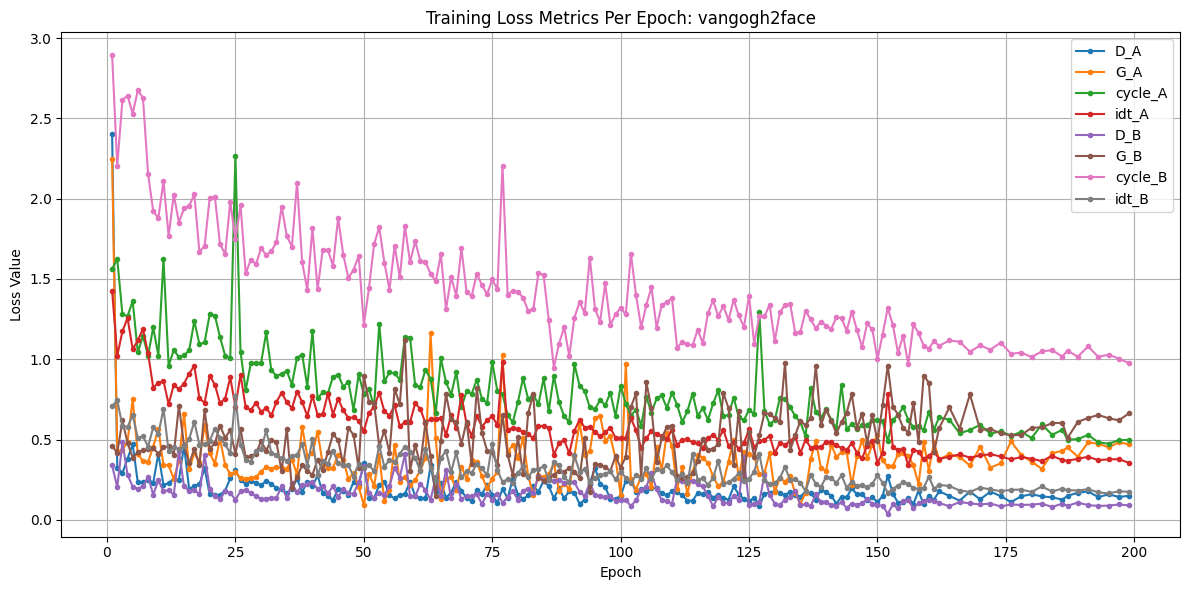

In [5]:
vangogh_results = parser(vangogh_path)
loss_plot(vangogh_results,'vangogh2face')

**Training Results**

In [6]:
!python pytorch-CycleGAN-and-pix2pix/test.py --dataroot datasets/datasets/monet2face/trainB --name vangogh2face --model test --no_dropout --gpu_ids -1

^C


**Testing Results**

In [7]:
!python pytorch-CycleGAN-and-pix2pix/test.py --dataroot datasets/datasets/monet2face --name vangogh2face --model cycle_gan --no_dropout --gpu_ids -1

^C


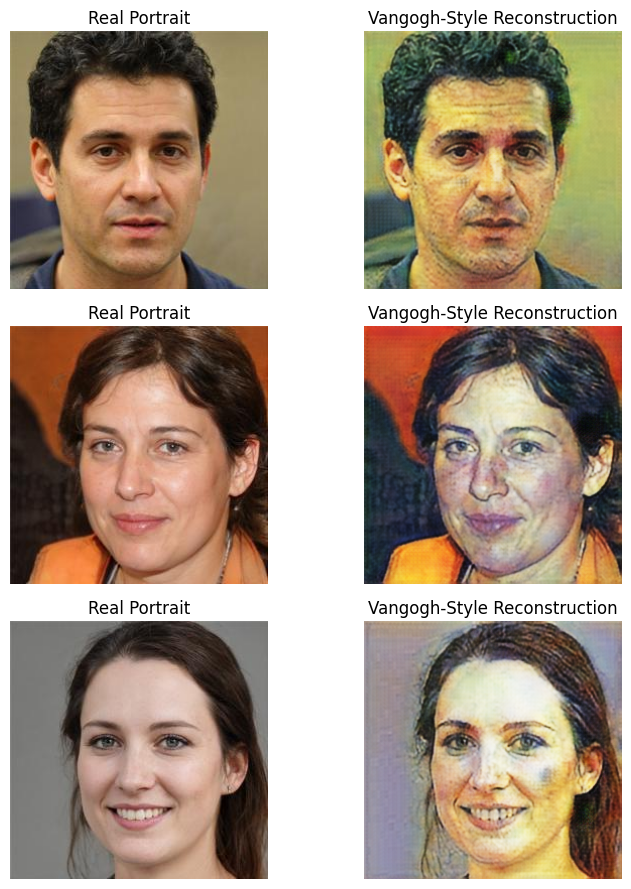

In [16]:
def show_random_realB_recB(image_dir, sample_size, style):
    # List all files in the directory
    all_files = os.listdir(image_dir)

    # Filter for _real_B.png images
    real_B_files = [f for f in all_files if f.endswith('_real_B.png')]

    # Randomly sample
    selected_real_B = random.sample(real_B_files, sample_size)

    # Prepare plots
    fig, axes = plt.subplots(sample_size, 2, figsize=(8, 3 * sample_size))

    for i, real_B_file in enumerate(selected_real_B):
        # Load real_B image
        real_B_img = Image.open(os.path.join(image_dir, real_B_file))

        # Corresponding rec_B image
        prefix = real_B_file.split('_')[0]
        rec_B_file = f"{prefix}_rec_B.png"
        rec_B_img = Image.open(os.path.join(image_dir, rec_B_file))

        # Plot side-by-side with descriptive labels
        axes[i, 0].imshow(real_B_img)
        axes[i, 0].set_title("Real Portrait")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(rec_B_img)
        axes[i, 1].set_title(f'{style} Reconstruction')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
show_random_realB_recB('results/vangogh2face/test_latest/images', 3, 'Vangogh-Style')
